In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from confidence_interval import calculate_confidence_interval, compare_model_accuracies
from charts import model_swarmplot

plt.rcParams["svg.hashsalt"] = "my_deterministic_salt"

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

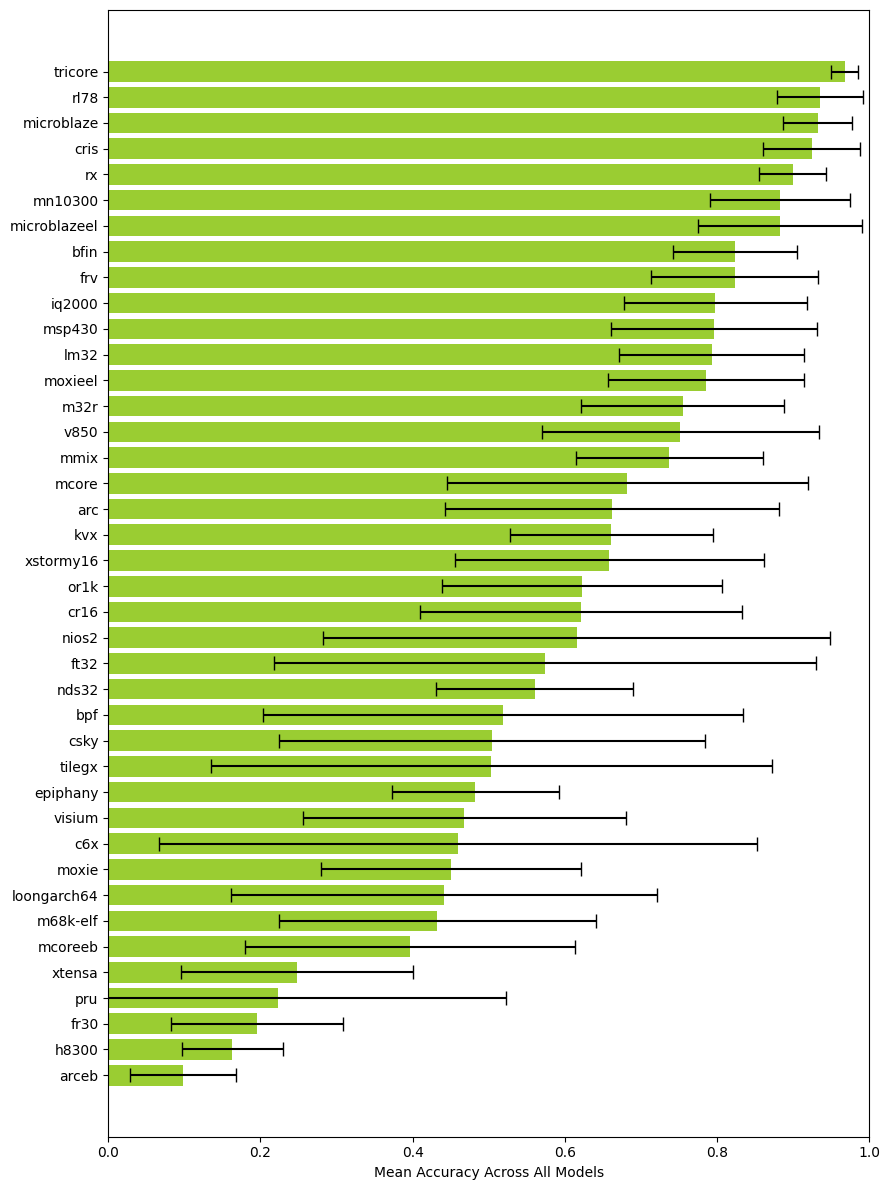

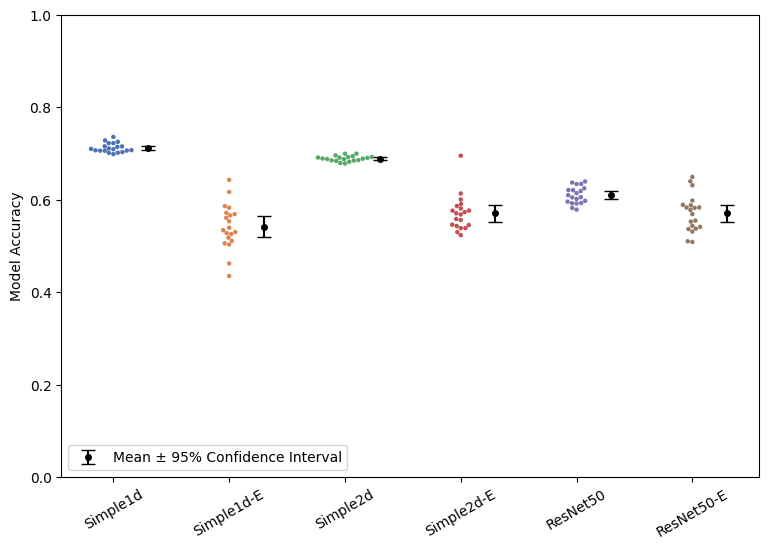

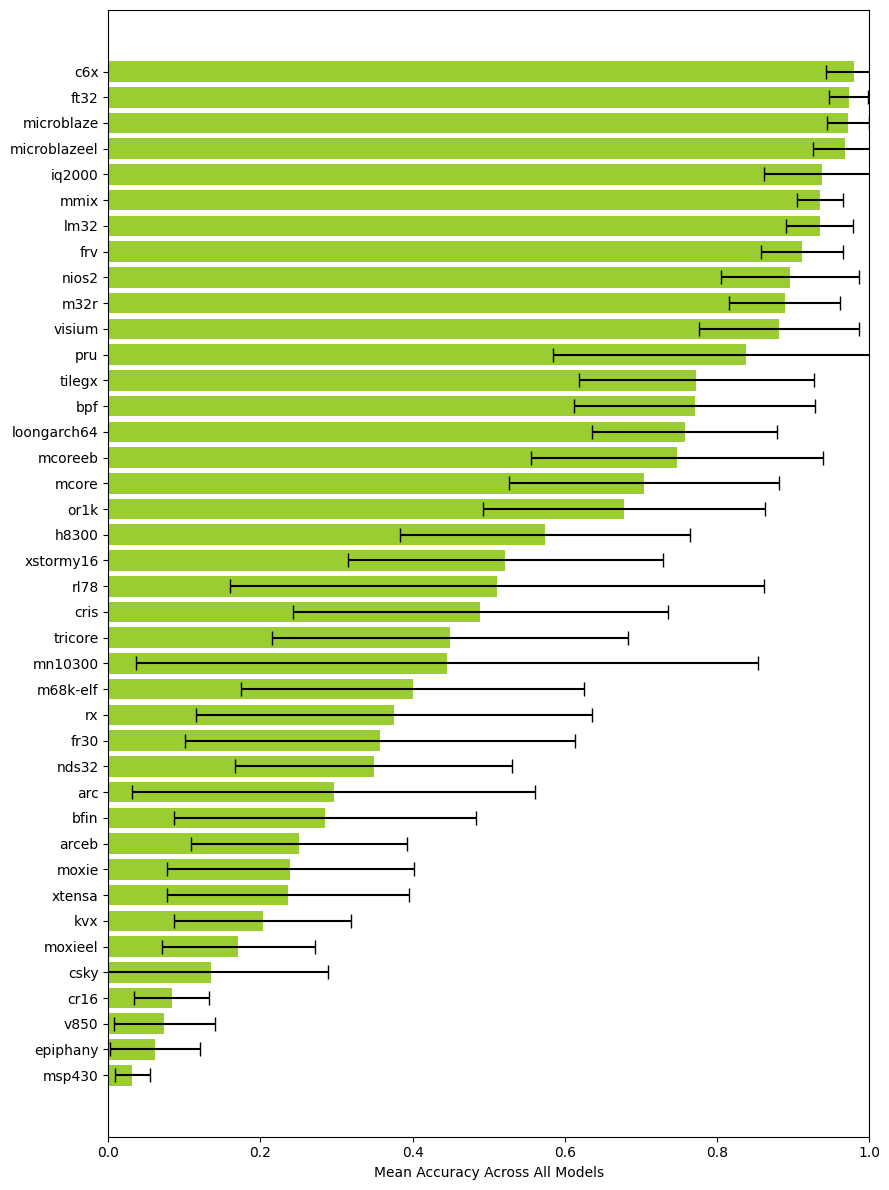

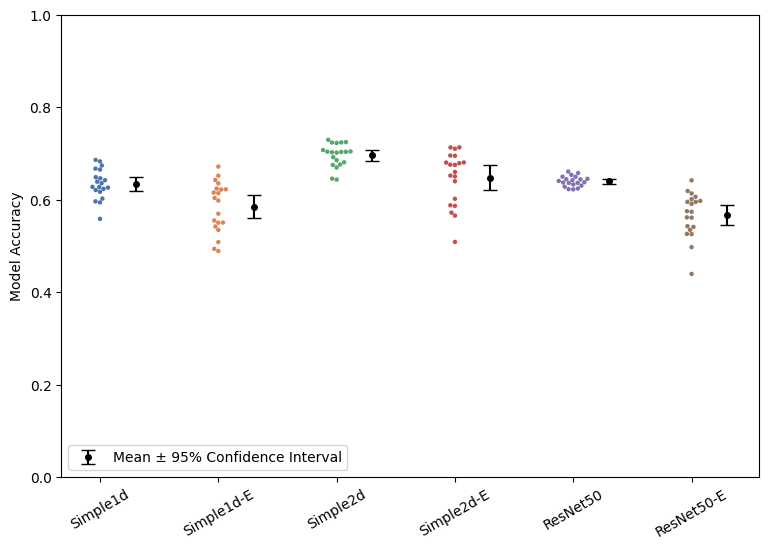

In [2]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "BuildCross-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        samples_count_cols = [
            col for col in df.columns if col.startswith("instance_count_")
        ]
        df["total_samples_count"] = df[samples_count_cols].sum(axis=1).astype(int)

        # Ensure all rows have the same total instance count
        assert (
            df["total_samples_count"] == df["total_samples_count"].iloc[0]
        ).all(), "Not all rows have the same samples count."

        samples_per_run = int(df["total_samples_count"].iloc[0])

        run_accuracies = df["test_accuracy"].tolist()
        model_mean, model_conf_95, _, _ = calculate_confidence_interval(
            run_accuracies, n_samples=samples_per_run, confidence=0.95
        )

        model_results[model_name] = (model_mean, run_accuracies, model_conf_95)

        # Collect per-architecture results
        for arch_col in arch_columns:
            arch = arch_col.replace("test_accuracy_", "")
            if arch not in arch_model_results:
                arch_model_results[arch] = {}

            arch_mean = df[arch_col].mean()
            arch_std = df[arch_col].std()
            arch_model_results[arch][model_name] = (arch_mean, arch_std)

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                values.append(arch_model_results[arch][model][0])
        if values:  # Only calculate if we have values
            arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (ascending)
    sorted_architectures = sorted(
        arch_means.keys(), key=lambda x: arch_means[x], reverse=False
    )

    # Create horizontal bar chart aggregated by architecture
    plt.figure(figsize=(9, 12))
    arch_means_list = []
    arch_stds_list = []

    for arch in sorted_architectures:
        arch_values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                arch_values.append(arch_model_results[arch][model][0])
        if arch_values:  # Only calculate if we have values
            arch_means_list.append(np.mean(arch_values))
            arch_stds_list.append(np.std(arch_values))

    bars = plt.barh(
        range(len(sorted_architectures)),
        arch_means_list,
        xerr=arch_stds_list,
        capsize=5,
        color="yellowgreen",
    )
    plt.yticks(range(len(sorted_architectures)), sorted_architectures)
    plt.xlabel("Mean Accuracy Across All Models")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/buildcross-{target_feature.replace('_', '').lower()}-by-isa.svg",
        metadata={"Date": None},
    )

    # Create bar chart aggregated by model
    model_means = []
    model_accuracies: list[list[float]] = []
    model_conf_95s = []
    model_labels = []

    for model in model_names:
        mean, model_accs, conf_95 = model_results[model]
        model_means.append(mean)
        model_accuracies.append(model_accs)
        model_conf_95s.append(conf_95)
        model_labels.append(model.replace("Embedding", "-E"))

    model_swarmplot(
        model_names=model_labels,
        model_accuracies=model_accuracies,
        model_95s=model_conf_95s,
        target_feature=target_feature,
        file_name=f"output/buildcross-{target_feature.replace('_', '').lower()}-by-model.svg",
        size=3.2,
    )

In [3]:
# Create a combined results table per architecture
for target_feature in target_features:
    model_results = {}
    arch_model_results = {}
    all_architectures = set()

    # Find all architecture columns
    arch_columns = [
        col
        for col in df_all.columns
        if col.startswith("test_accuracy_") and col != "test_accuracy"
    ]
    architectures = [col.replace("test_accuracy_", "") for col in arch_columns]
    all_architectures.update(architectures)

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        samples_count_cols = [
            col for col in df.columns if col.startswith("instance_count_")
        ]
        df["total_samples_count"] = df[samples_count_cols].sum(axis=1).astype(int)

        # Ensure all rows have the same total instance count
        assert (
            df["total_samples_count"] == df["total_samples_count"].iloc[0]
        ).all(), "Not all rows have the same samples count."

        samples_per_run = int(df["total_samples_count"].iloc[0])

        model_mean, model_conf_95, _, _ = calculate_confidence_interval(
            accuracies=df["test_accuracy"], n_samples=samples_per_run, confidence=0.95
        )

        overall_std = df["test_accuracy"].std()

        model_results[model_name] = (model_mean, overall_std, model_conf_95)

        # Collect per-architecture results
        for arch_col in arch_columns:
            arch = arch_col.replace("test_accuracy_", "")
            if arch not in arch_model_results:
                arch_model_results[arch] = {}

            arch_mean = df[arch_col].mean()
            arch_std = df[arch_col].std()
            arch_model_results[arch][model_name] = (arch_mean, arch_std)

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                values.append(arch_model_results[arch][model][0])
        if values:  # Only calculate if we have values
            arch_means[arch] = np.mean(values)

    # Sort architectures by name (alphabetically)
    sorted_architectures = sorted(all_architectures, key=lambda x: x.lower())

    # Create the combined table
    table_string = "| Architecture |"
    for model in model_names:
        table_string += f" {model.replace("Embedding", "-E")} |"
    table_string += "\n| ------------ |"
    table_string += " ------------: |" * len(model_names)
    table_string += "\n"

    # Add rows for each architecture
    for arch in sorted_architectures:
        table_string += f"| {arch} |"
        for model in model_names:
            if arch in arch_model_results and model in arch_model_results[arch]:
                mean, conf_95 = arch_model_results[arch][model]
                table_string += f" {mean:.3f}±{conf_95:.3f} |"

        table_string += "\n"

    table_string += "| **Overall** |"
    for model in model_names:
        mean, std, _ = model_results[model]
        table_string += f" **{mean:.3f}±{std:.3f}** |"
    table_string += "\n"

    table_string += "| **95% CI** |"
    for model in model_names:
        mean, std, conf_95 = model_results[model]
        table_string += f" **{(mean-conf_95):.3f}--{(mean+conf_95):.3f}** |"
    table_string += "\n"

    # Save the table
    filename = f"output/buildcross-{target_feature.replace('_', '').lower()}-combined-results.md"
    with open(filename, "w") as f:
        f.write(table_string)

    print(f"Results table for {target_feature}:")
    print(table_string)

Results table for endianness:
| Architecture | Simple1d | Simple1d-E | Simple2d | Simple2d-E | ResNet50 | ResNet50-E |
| ------------ | ------------: | ------------: | ------------: | ------------: | ------------: | ------------: |
| arc | 0.910±0.048 | 0.358±0.272 | 0.873±0.067 | 0.379±0.256 | 0.764±0.078 | 0.688±0.221 |
| arceb | 0.032±0.027 | 0.065±0.046 | 0.067±0.036 | 0.056±0.043 | 0.238±0.044 | 0.133±0.130 |
| bfin | 0.940±0.046 | 0.742±0.148 | 0.918±0.044 | 0.720±0.165 | 0.811±0.038 | 0.813±0.132 |
| bpf | 0.005±0.014 | 0.825±0.276 | 0.180±0.124 | 0.812±0.305 | 0.576±0.146 | 0.713±0.292 |
| c6x | 0.114±0.129 | 0.949±0.135 | 0.002±0.003 | 0.991±0.014 | 0.185±0.111 | 0.517±0.285 |
| cr16 | 0.935±0.044 | 0.379±0.137 | 0.839±0.071 | 0.424±0.173 | 0.470±0.078 | 0.679±0.149 |
| cris | 0.992±0.008 | 0.857±0.131 | 0.997±0.003 | 0.838±0.119 | 0.967±0.011 | 0.897±0.080 |
| csky | 0.817±0.105 | 0.168±0.121 | 0.890±0.057 | 0.208±0.217 | 0.576±0.115 | 0.368±0.191 |
| epiphany | 0.595±0.179 |